In [ ]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import os
import pickle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers

### `Reading the messages`

##Getting the dataset

Actually getting the dataset of all my conversations was surprisingly straightforward. All I had to do was visit the “Download your information” tab here, and ensure the checkbox next to “Messages” was the only one clicked. I also selected the “JSON” option for format. After submitting a request for my data, I waited for about an hour before I received an email saying my files were ready. I downloaded my messages as a .zip file (which was about 1.5gb while compressed!) and extracted the file into a directory with python scripts for parsing and generating text.

In [ ]:
! wget --header="Host: bigzipfiles.facebook.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.92 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.facebook.com/" --header="Cookie: sb=rmORXkHzq4zGwZCRMwFUOuNW; datr=tkyVXiAsc_meJnv9HZvZLrQJ; c_user=100003852074416; xs=25%3AGeZKtYaMMPEVFQ%3A2%3A1589466034%3A6479%3A3656; spin=r.1002244099_b.trunk_t.1592062863_s.1_v.2_; _fbp=fb.1.1592118527858.1441407236; fr=088w4bb3d0cmEw1pX.AWWIdq9JgnDAmTvb5z9ArTFHuHE.Be4iJJ.jo.F7j.0.0.Be5gOL.AWWLFz0A; wd=1299x637; presence=EDvF3EtimeF1592135257EuserFA21B03852074416A2EstateFDutF1592135257014CEchF_7bCC; act=1592135257988%2F1" --header="Connection: keep-alive" "https://bigzipfiles.facebook.com/p/dl/download/file.php?r=100003852074416&t=100003852074416&j=11&i=1699478706857182&f=1699495213522198&ext=1592137668&hash=AaDAKwV7DvVSTsP1" -c -O 'facebook-milangautam904.zip'

--2020-06-14 11:48:06--  https://bigzipfiles.facebook.com/p/dl/download/file.php?r=100003852074416&t=100003852074416&j=11&i=1699478706857182&f=1699495213522198&ext=1592137668&hash=AaDAKwV7DvVSTsP1
Resolving bigzipfiles.facebook.com (bigzipfiles.facebook.com)... 157.240.3.29, 2a03:2880:f001:b:face:b00c:0:3
Connecting to bigzipfiles.facebook.com (bigzipfiles.facebook.com)|157.240.3.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6530488842 (6.1G) [application/zip]
Saving to: ‘facebook-milangautam904.zip’

facebook-milangauta 100%[===================>]   6.08G  22.2MB/s    in 4m 54s  

2020-06-14 11:53:00 (21.2 MB/s) - ‘facebook-milangautam904.zip’ saved [6530488842/6530488842]



In [ ]:
!mkdir facebook
!unzip 'facebook-milangautam904.zip' -d 'facebook'

Streaming output truncated to the last 5000 lines.
  inflating: facebook/messages/inbox/BCT074_Official_R1cpz7GOzA/photos/37107665_1826560180744639_5099147235812179968_n_1826560174077973.jpg  
  inflating: facebook/messages/inbox/BCT074_Official_R1cpz7GOzA/photos/37054925_1810571232360364_4108934601504718848_n_1810578052359682.jpg  
  inflating: facebook/messages/inbox/BCT074_Official_R1cpz7GOzA/photos/37250907_1633509156746986_7250254783943016448_n_1633509080080327.jpg  
  inflating: facebook/messages/inbox/BCT074_Official_R1cpz7GOzA/photos/36889839_1623253744439194_3176379124302217216_n_1623253631105872.jpg  
  inflating: facebook/messages/inbox/BCT074_Official_R1cpz7GOzA/photos/37791983_2210374465857670_1846663726271299584_n_2210374459191004.png  
  inflating: facebook/messages/inbox/BCT074_Official_R1cpz7GOzA/gifs/30860052_2072121396388334_1753511550682923008_n_216705679256819.gif  
  inflating: facebook/messages/inbox/BCT074_Official_R1cpz7GOzA/gifs/32178587_10204899884255079_2469

In [ ]:
dir_path='facebook/messages/inbox'
Root=Path(dir_path)
path_to_all=list(Root.glob('*/message_1.json'))

In [ ]:
#Getting all the text content from all the message
path_to_all=[str(path) for path in path_to_all]
contents=' '.join(str(tf.io.read_file(path).numpy()) for path in path_to_all)

## Preprocessing

In [ ]:
clean_contents=re.findall('"content": "[\w\?\.><;:\+()\*&\^%\$#@! ]*"',contents)
clean_contents=''.join(con for con in clean_contents)
#Removing all the "content:"
clean_contents=re.sub('"content":',' ',clean_contents)
#Removing all the ""
clean_contents=re.sub('"','',clean_contents)
#Removing all the "you missed the call"
clean_contents=re.sub('You missed a call','',clean_contents)
#Remove 'from name'
clean_contents=re.sub('from [\w]*','',clean_contents)
#Remove 'joined the video chat'
clean_contents=re.sub('[\w]* joined the video chat*','',clean_contents)
#Remove 'left the group'
clean_contents=re.sub('[\w]* left the group','',clean_contents)
clean_contents=re.sub('[\w]* to join the group','',clean_contents)
clean_contents=re.sub('[\w]* can join the group','',clean_contents)

In [ ]:
char_to_index=dict((value,index) for index,value in enumerate(set(clean_contents)))
index_to_char=dict((index,value) for index,value in enumerate(set(clean_contents)))
print('The vocabolary size in the messages:',len(char_to_index))
print('\n The total number of characters in all the messages are:',len(clean_contents))

The vocabolary size in the messages: 81

 The total number of characters in all the messages are: 1757397


The total number of character in messages are 1826026.The length of the vocabolary is 81

In [ ]:
#Encoding the messages
numerical_contents=[char_to_index[char] for char in clean_contents]

#saving all the numerical contents in the drive
np.save('/content/drive/My Drive/facebook',numerical_contents)
with open('/content/drive/My Drive/char_to_index.pkl','wb') as f:
    pickle.dump(char_to_index,f, pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/index_to_char.pkl','wb') as f:
    pickle.dump(index_to_char,f, pickle.HIGHEST_PROTOCOL)


In [ ]:
#Loading all the preprocessed values from the drive
numerical_contents=np.load('/content/drive/My Drive/facebook.npy')
with open('/content/drive/My Drive/char_to_index.pkl','rb') as f:
    char_to_index=pickle.load(f)
with open('/content/drive/My Drive/index_to_char.pkl','rb') as f:
    index_to_char=pickle.load(f)


## Creating the model and training it.

**The** **most** **important** **thing** **when** **dealing** **with** **RNN** **are** **creating** **the** **batch** **size**.

How much sequential information do we want to learn depends upon the batch size. The total characters in our data=1757397, we will create a batch size of 128. Therefore there will be 128 sequencial block of data as:

Total_data/batch_size => 1757397/200 => 8786 and each block will be a sequence of 14394, so by using "statefull=True", we can provide immense prower to RNN.

  Suppose a RNN of 64 cell, each cell will process a single character only 64 character will be processed by this RNN and the sequential learning will be limited by this characteristics. By using statefull method this RNN will be capable of learning 14394 characters sequentially.

In [ ]:
#If overfitting happens need to change this 
#train=numerical_contents[:int(len(numerical_contents)*75/100)] #75% in training data
#test=numerical_contents[int(len(numerical_contents)*75/100):]  #25% in test data
#print('The size of the training data:',len(train))
#print('The size of the test data:',len(test))

#Difining the parameters
batch_size=200
sequence_len=64
epochs=150
steps_on_epoch=int(len(numerical_contents)/batch_size/sequence_len) 
vocab_size=81
block_size=8786
print('The number of steps in each epoch is :',steps_on_epoch)

The number of steps in each epoch is : 137


In [ ]:
'''
1st_batch:                  2nd_batch:                       
[0:64]                      [64:64*2]  
[14208:14208+64]            [14208+64:14208+64+64]
[14208*2:14208*2+64]        [14208*2+64:14208*2+64+64]  
[14208*3:14208*3+64]        [14208*3:14208*3+64]
    .  .   .
    .  .   .
[14208*127:14208*127+64]      

Therefore, the selection code will be like this:

T[steps_on_epoch*sequence_length+block_size*data_point:steps_on_epoch*sequence_length+block_size*datapoint+sequence_length]

In simple terms:

1st_batch:                                               2nd_batch:
[0*64+14208*0:0*64+14208*0+64]=[0:64]                    [1*64+14208*0:1*64+14208*0+64]=[64:64+64] 
[0*64+14208*1:0*64+14208*1+64]=[14208:14208+64]          [1*64+14208*1:1*64+14208*1+64]=[64+14208:64+14208+64] 

'''

def Selecting_batch(T,steps_on_epochs):
    X=np.zeros([batch_size,sequence_len]) #[64,68,81]
    y=np.zeros([batch_size,sequence_len,vocab_size]) #[16,64,81]
    
    Reference=steps_on_epochs*sequence_len+block_size #indicating where to select the data point

    for datapoint in range(batch_size):
        #selecting one datapoint
        one_datapoint_x=T[steps_on_epochs*sequence_len+block_size*datapoint : steps_on_epochs*sequence_len+block_size*datapoint+sequence_len]
  
        one_datapoint_y=T[steps_on_epochs*sequence_len+block_size*datapoint+1 : steps_on_epochs*sequence_len+block_size*datapoint+sequence_len+1]

        one_hot_encoder=np.zeros([sequence_len,vocab_size])
        
        for i in range(sequence_len):
             one_hot_encoder[i,one_datapoint_y[i]]=1

        X[datapoint]=one_datapoint_x
        y[datapoint]=one_hot_encoder
    return X,y

This makes it clear that there is no problem in the batching of our data the error is there because of the other factor

Defining the parameters

In [ ]:
parameters={

    'Wx':np.random.unifro,
    'Wy':,
    'Wo':

    'ba':,
    'by':,
}

shape of Wx=[81,512]
,Wo=[512,512]
Wy=[512,81]

In [ ]:
def Relu(X):
     return(np.where(X<0,0,X)) 

def softmax(X):
    e_x = np.exp(X-np.max(X))
    return e_x / e_x.sum(axis=0)

def loss_function(y,output):
    return((-y*np.log(output+0.000000001)).mean())


In [ ]:
def Forward_propogation_cell(x,y,previous_cell_output):

    Wx=parameters['Wx'] 
    Wy=parameters['Wy']
    Wo=parameters['Wo']
    by=parameters['by']
    ba=parameters['ba'] 

    Z=np.dot(x,Wx)+np.dot(previous_cell_output,Wo)+ba
    new_cell_output=Relu(Z)

    Zy=np.dot(new_cell_output,Wy)+by #Creating dense layer for producting the output
    output=softmax(Zy) #This output is going to be the next word

    cache={
        'Z':Z,
        'Zy':Zy,
        'new_cell_output':new_cell_output,
        'previous_cell_output':previous_cell_output,
        'x':x,
        'output':output,
        'y':y
    }

    return new_cell_output,cache,output

In [ ]:
def Forward_propagation(X,y):
    
    Wx=parameters['Wx'] 
    Wy=parameters['Wy']
    Wo=parameters['Wo']
    bx=parameters['bx']
    by=parameters['by']
    bo=parameters['bo']
    
    previous_cell_output=np.zeros([64,512])
    caches=[]
    outputs=[]

    for i in range(sequence_len):

        new_cell_output,cache,output=Forward_propagation_cell(X[:,i,:],y[:,i,:],previous_cell_output)
        caches.append(cache)
        outputs.append(output)
        previous_cell_output=new_cell_output

    return outputs,caches

Derivative of loss function with respect to softmax output=dL/d(output)=(-y/output)

In [ ]:
def Back_propagation_cell(output,cache,derivative_of_output):

    #Calculating the derivative of the cross_entopy loss function
    output= 



In [ ]:
def Back_propagation(Outputs,caches):

    derivative_of_output=0

    for i in reversed(range(len(Outputs))):
        derivative_of_previous_output,dwx,dwy,dwo=Back_propagation_cell(outputs[i],caches[i],derivative_of_output)

        darivative_of_output=derivative_of_previous_output

     gradients={
         'dWx':,
         'dWy':,
         'dWo':

     }   




In [ ]:
#model architecture
def create_model(batch_size,sequence_len):

 model=Sequential()
 model.add(layers.Embedding(vocab_size,50,batch_input_shape=(batch_size,sequence_len)))
 model.add(layers.LSTM(512,return_sequences=True,stateful=True))
 model.add(layers.Dropout(0.3))
 model.add(layers.LSTM(512,return_sequences=True,stateful=True))
 model.add(layers.Dropout(0.3))
 model.add(layers.LSTM(512,return_sequences=True,stateful=True))
 model.add(layers.Dropout(0.3))
 model.add(layers.TimeDistributed(layers.Dense(vocab_size)))
 model.add(layers.Activation('softmax'))
 return model

In [ ]:
model=create_model(batch_size,sequence_len)
#model.load_weights('/content/drive/My Drive/model_weights')
model.compile(optimizer='adam',metrics='accuracy',loss='categorical_crossentropy')
model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (200, 64, 50)             4050      
_________________________________________________________________
lstm_152 (LSTM)              (200, 64, 512)            1153024   
_________________________________________________________________
dropout_144 (Dropout)        (200, 64, 512)            0         
_________________________________________________________________
lstm_153 (LSTM)              (200, 64, 512)            2099200   
_________________________________________________________________
dropout_145 (Dropout)        (200, 64, 512)            0         
_________________________________________________________________
lstm_154 (LSTM)              (200, 64, 512)            2099200   
_________________________________________________________________
dropout_146 (Dropout)        (200, 64, 512)          

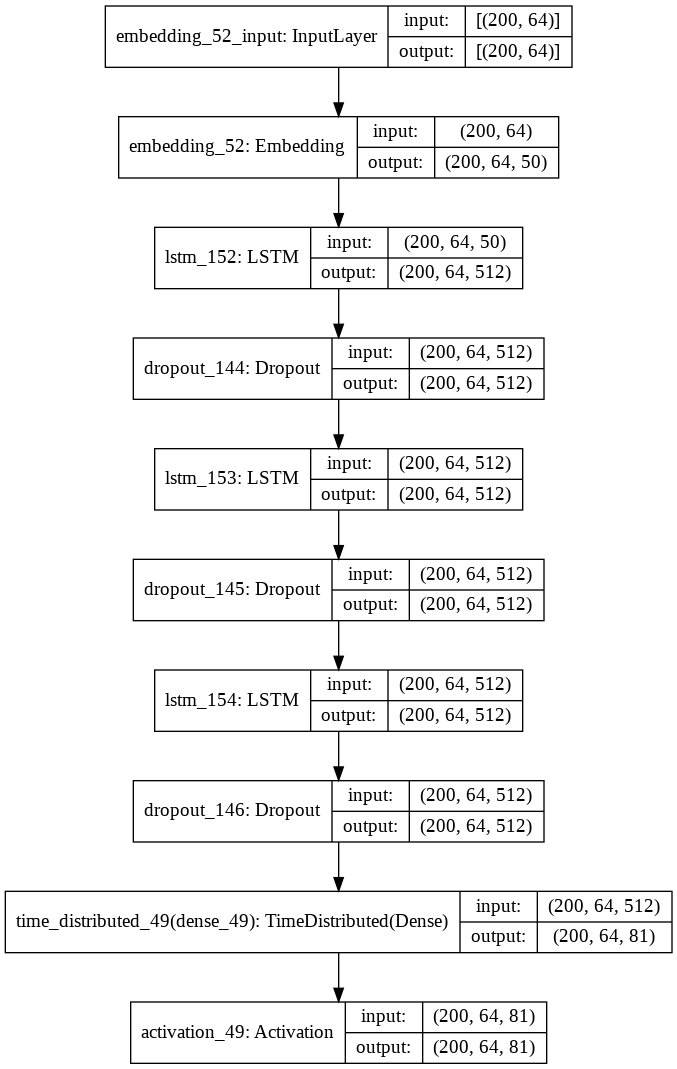

In [ ]:
#Visualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
#Now training our network
#tf.keras.backend.clear_session()
for epoch in tqdm(range(epochs)):
    losses=[]
    accuracy=[]

    if epoch%10==0:
        model.save_weights('/content/drive/My Drive/new_model_weights')

    for step in (range(steps_on_epoch)):

        #Getting batches of train and test
        X,Y=Selecting_batch(numerical_contents,step) #X=[68,64,81],y=[68,64,81]
        loss,acc=model.train_on_batch(X,Y,reset_metrics=False)
        losses.append(loss)
        accuracy.append(acc)
      
    print('\tLoss:',np.mean(np.array(losses)),', Accuracy :',np.mean(np.array(accuracy))) 
    




  0%|          | 0/150 [00:00<?, ?it/s]


  1%|          | 1/150 [00:17<44:11, 17.80s/it]

	Loss: 3.1915688653932 , Accuracy : 0.2012331832445016





  1%|▏         | 2/150 [00:32<41:30, 16.82s/it]

	Loss: 2.9035801626469966 , Accuracy : 0.24209782448563263





  2%|▏         | 3/150 [00:46<39:32, 16.14s/it]

	Loss: 2.667803442391166 , Accuracy : 0.29029501506881994





  3%|▎         | 4/150 [01:01<38:06, 15.66s/it]

	Loss: 2.4903160881822126 , Accuracy : 0.3312446677336728





  3%|▎         | 5/150 [01:15<37:01, 15.32s/it]

	Loss: 2.3552272772266916 , Accuracy : 0.3637602914423838





  4%|▍         | 6/150 [01:30<36:14, 15.10s/it]

	Loss: 2.2478341917051887 , Accuracy : 0.39014023259608416





  5%|▍         | 7/150 [01:45<35:34, 14.93s/it]

	Loss: 2.1602078302063212 , Accuracy : 0.411856517086934





  5%|▌         | 8/150 [01:59<35:04, 14.82s/it]

	Loss: 2.0874175416292067 , Accuracy : 0.430049355012657





  6%|▌         | 9/150 [02:14<34:37, 14.73s/it]

	Loss: 2.026057079760698 , Accuracy : 0.4454014584095809





  7%|▋         | 10/150 [02:28<34:15, 14.68s/it]

	Loss: 1.973559751127758 , Accuracy : 0.45855599794074564





  7%|▋         | 11/150 [02:43<34:06, 14.73s/it]

	Loss: 1.9281238134760057 , Accuracy : 0.4699510222803937





  8%|▊         | 12/150 [02:58<33:46, 14.69s/it]

	Loss: 1.8883387833616159 , Accuracy : 0.4799152697524885





  9%|▊         | 13/150 [03:12<33:26, 14.65s/it]

	Loss: 1.8530707620356204 , Accuracy : 0.488732202862301





  9%|▉         | 14/150 [03:27<33:08, 14.62s/it]

	Loss: 1.8215747071008612 , Accuracy : 0.49659813516331414





 10%|█         | 15/150 [03:41<32:51, 14.60s/it]

	Loss: 1.7931920377007367 , Accuracy : 0.5036968079796673





 11%|█         | 16/150 [03:56<32:37, 14.61s/it]

	Loss: 1.767560353244308 , Accuracy : 0.5101134315894468





 11%|█▏        | 17/150 [04:11<32:22, 14.61s/it]

	Loss: 1.7441500425338745 , Accuracy : 0.5159627355798317





 12%|█▏        | 18/150 [04:25<32:07, 14.60s/it]

	Loss: 1.722688717563657 , Accuracy : 0.5213129650937379





 13%|█▎        | 19/150 [04:40<31:52, 14.60s/it]

	Loss: 1.7029108070109011 , Accuracy : 0.5262437889175694





 13%|█▎        | 20/150 [04:54<31:35, 14.58s/it]

	Loss: 1.6846233197372324 , Accuracy : 0.5308049821505582





 14%|█▍        | 21/150 [05:09<31:33, 14.68s/it]

	Loss: 1.6676512782591102 , Accuracy : 0.5350381892963048





 15%|█▍        | 22/150 [05:24<31:16, 14.66s/it]

	Loss: 1.6518181866972985 , Accuracy : 0.5389854834027534





 15%|█▌        | 23/150 [05:38<31:00, 14.65s/it]

	Loss: 1.6369739118283682 , Accuracy : 0.5426772228122627





 16%|█▌        | 24/150 [05:53<30:46, 14.65s/it]

	Loss: 1.6230406665453945 , Accuracy : 0.5461536628486466





 17%|█▋        | 25/150 [06:08<30:29, 14.64s/it]

	Loss: 1.609857210277641 , Accuracy : 0.5494386836560103





 17%|█▋        | 26/150 [06:22<30:13, 14.63s/it]

	Loss: 1.5973788134373017 , Accuracy : 0.5525419024655419





 18%|█▊        | 27/150 [06:37<29:57, 14.61s/it]

	Loss: 1.5855525801651669 , Accuracy : 0.5554829035362188





 19%|█▊        | 28/150 [06:51<29:42, 14.61s/it]

	Loss: 1.5743394289573613 , Accuracy : 0.558264709737179





 19%|█▉        | 29/150 [07:06<29:28, 14.61s/it]

	Loss: 1.563688973440741 , Accuracy : 0.5609045311482284





 20%|██        | 30/150 [07:21<29:13, 14.62s/it]

	Loss: 1.553513209315112 , Accuracy : 0.5634272968682059





 21%|██        | 31/150 [07:36<29:07, 14.69s/it]

	Loss: 1.5438247475310833 , Accuracy : 0.5658286701153664





 21%|██▏       | 32/150 [07:50<28:51, 14.68s/it]

	Loss: 1.53457824940229 , Accuracy : 0.5681156855430046





 22%|██▏       | 33/150 [08:05<28:34, 14.66s/it]

	Loss: 1.5256868940200248 , Accuracy : 0.5703097751540859





 23%|██▎       | 34/150 [08:20<28:20, 14.66s/it]

	Loss: 1.517156320766811 , Accuracy : 0.5724242212128465





 23%|██▎       | 35/150 [08:34<28:06, 14.67s/it]

	Loss: 1.508967864252355 , Accuracy : 0.5744484867492732





 24%|██▍       | 36/150 [08:49<27:54, 14.69s/it]

	Loss: 1.5010870277446553 , Accuracy : 0.5763989913202551





 25%|██▍       | 37/150 [09:04<27:42, 14.71s/it]

	Loss: 1.4935050263021985 , Accuracy : 0.5782690039516365





 25%|██▌       | 38/150 [09:18<27:29, 14.73s/it]

	Loss: 1.4861818056036955 , Accuracy : 0.5800805609591686





 26%|██▌       | 39/150 [09:33<27:16, 14.74s/it]

	Loss: 1.4790872405045223 , Accuracy : 0.5818351624655898





 27%|██▋       | 40/150 [09:48<27:02, 14.75s/it]

	Loss: 1.472236329621642 , Accuracy : 0.583529885667954





 27%|██▋       | 41/150 [10:03<26:58, 14.85s/it]

	Loss: 1.4656145920718673 , Accuracy : 0.5851647584107671





 28%|██▊       | 42/150 [10:18<26:42, 14.84s/it]

	Loss: 1.4592002839067557 , Accuracy : 0.586750832352325





 29%|██▊       | 43/150 [10:33<26:27, 14.83s/it]

	Loss: 1.4529953977487382 , Accuracy : 0.5882874218216778





 29%|██▉       | 44/150 [10:47<26:09, 14.80s/it]

	Loss: 1.4469747299695537 , Accuracy : 0.5897770219475683





 30%|███       | 45/150 [11:02<25:53, 14.80s/it]

	Loss: 1.44116600499536 , Accuracy : 0.5912145223930805





 31%|███       | 46/150 [11:17<25:36, 14.78s/it]

	Loss: 1.4355500779882835 , Accuracy : 0.5926037817975901





 31%|███▏      | 47/150 [11:32<25:21, 14.77s/it]

	Loss: 1.4301007638012406 , Accuracy : 0.5939465460986116





 32%|███▏      | 48/150 [11:46<25:06, 14.77s/it]

	Loss: 1.4247829783571897 , Accuracy : 0.5952606005390195





 33%|███▎      | 49/150 [12:01<24:51, 14.77s/it]

	Loss: 1.4195997732399155 , Accuracy : 0.596541613557913





 33%|███▎      | 50/150 [12:16<24:37, 14.77s/it]

	Loss: 1.4145323960450444 , Accuracy : 0.5977964227216958





 34%|███▍      | 51/150 [12:31<24:32, 14.87s/it]

	Loss: 1.4095984070840544 , Accuracy : 0.5990132415381662





 35%|███▍      | 52/150 [12:46<24:14, 14.84s/it]

	Loss: 1.40477725624168 , Accuracy : 0.6002057085942177





 35%|███▌      | 53/150 [13:01<23:57, 14.82s/it]

	Loss: 1.4000648347130658 , Accuracy : 0.6013744060140457





 36%|███▌      | 54/150 [13:15<23:40, 14.80s/it]

	Loss: 1.3954565342325365 , Accuracy : 0.6025171584456507





 37%|███▋      | 55/150 [13:30<23:24, 14.79s/it]

	Loss: 1.3909693556110354 , Accuracy : 0.6036229177112997





 37%|███▋      | 56/150 [13:45<23:09, 14.78s/it]

	Loss: 1.3865909445894895 , Accuracy : 0.6047006084101043





 38%|███▊      | 57/150 [14:00<22:54, 14.78s/it]

	Loss: 1.3823077844007172 , Accuracy : 0.6057558573075454





 39%|███▊      | 58/150 [14:15<22:40, 14.79s/it]

	Loss: 1.3780949124454582 , Accuracy : 0.6067950869128652





 39%|███▉      | 59/150 [14:29<22:25, 14.79s/it]

	Loss: 1.3739859135481562 , Accuracy : 0.6078123811387668





 40%|████      | 60/150 [14:44<22:10, 14.79s/it]

	Loss: 1.3699559129937722 , Accuracy : 0.6088087075818194





 41%|████      | 61/150 [14:59<22:04, 14.88s/it]

	Loss: 1.3660139237007085 , Accuracy : 0.6097834493121962





 41%|████▏     | 62/150 [15:14<21:47, 14.85s/it]

	Loss: 1.3621602737120468 , Accuracy : 0.6107339819852453





 42%|████▏     | 63/150 [15:29<21:30, 14.83s/it]

	Loss: 1.3583867314958225 , Accuracy : 0.6116660341729213





 43%|████▎     | 64/150 [15:44<21:15, 14.83s/it]

	Loss: 1.3546986066511948 , Accuracy : 0.6125772242998555





 43%|████▎     | 65/150 [15:58<20:59, 14.82s/it]

	Loss: 1.3510991543748954 , Accuracy : 0.6134656062961494





 44%|████▍     | 66/150 [16:13<20:43, 14.80s/it]

	Loss: 1.3475710066565632 , Accuracy : 0.6143375178323175





 45%|████▍     | 67/150 [16:28<20:27, 14.79s/it]

	Loss: 1.3440964874559946 , Accuracy : 0.6151953274316161





 45%|████▌     | 68/150 [16:43<20:12, 14.79s/it]

	Loss: 1.3407068583216981 , Accuracy : 0.6160304724735065





 46%|████▌     | 69/150 [16:57<19:57, 14.79s/it]

	Loss: 1.3373907787086319 , Accuracy : 0.6168500889826866





 47%|████▋     | 70/150 [17:12<19:42, 14.79s/it]

	Loss: 1.3341441137077164 , Accuracy : 0.6176523266047457





 47%|████▋     | 71/150 [17:27<19:33, 14.86s/it]

	Loss: 1.3309495640497138 , Accuracy : 0.6184439850549628





 48%|████▊     | 72/150 [17:42<19:17, 14.84s/it]

	Loss: 1.3278064597262083 , Accuracy : 0.6192218495981536





 49%|████▊     | 73/150 [17:57<19:00, 14.81s/it]

	Loss: 1.3247089673132793 , Accuracy : 0.6199872841800216





 49%|████▉     | 74/150 [18:12<18:44, 14.80s/it]

	Loss: 1.32166465355532 , Accuracy : 0.6207367803928626





 50%|█████     | 75/150 [18:26<18:28, 14.79s/it]

	Loss: 1.318667135099425 , Accuracy : 0.6214797618615366





 51%|█████     | 76/150 [18:41<18:13, 14.77s/it]

	Loss: 1.3157172777356894 , Accuracy : 0.6222104708643725





 51%|█████▏    | 77/150 [18:56<17:58, 14.77s/it]

	Loss: 1.3128298982216493 , Accuracy : 0.6229245245021625





 52%|█████▏    | 78/150 [19:11<17:43, 14.77s/it]

	Loss: 1.3099804838208386 , Accuracy : 0.6236312641714611





 53%|█████▎    | 79/150 [19:25<17:28, 14.76s/it]

	Loss: 1.3071835841575679 , Accuracy : 0.6243247663887748





 53%|█████▎    | 80/150 [19:40<17:12, 14.75s/it]

	Loss: 1.3044231338222532 , Accuracy : 0.6250094262352826





 54%|█████▍    | 81/150 [19:55<17:03, 14.83s/it]

	Loss: 1.3016985976783029 , Accuracy : 0.6256844540582086





 55%|█████▍    | 82/150 [20:10<16:47, 14.81s/it]

	Loss: 1.2990195507550761 , Accuracy : 0.6263506347245543





 55%|█████▌    | 83/150 [20:25<16:32, 14.81s/it]

	Loss: 1.2963831520428624 , Accuracy : 0.6270043027662012





 56%|█████▌    | 84/150 [20:39<16:17, 14.81s/it]

	Loss: 1.2937976678792578 , Accuracy : 0.6276443844294026





 57%|█████▋    | 85/150 [20:54<16:02, 14.80s/it]

	Loss: 1.291252122308216 , Accuracy : 0.6282735136303589





 57%|█████▋    | 86/150 [21:09<15:46, 14.79s/it]

	Loss: 1.2887416608142157 , Accuracy : 0.6288947384722912





 58%|█████▊    | 87/150 [21:24<15:31, 14.79s/it]

	Loss: 1.2862791588706692 , Accuracy : 0.6295081672877291





 59%|█████▊    | 88/150 [21:39<15:16, 14.78s/it]

	Loss: 1.2838425253429553 , Accuracy : 0.6301101989989734





 59%|█████▉    | 89/150 [21:53<15:01, 14.78s/it]

	Loss: 1.281437418756694 , Accuracy : 0.6307052417393149





 60%|██████    | 90/150 [22:08<14:46, 14.78s/it]

	Loss: 1.279073897069388 , Accuracy : 0.6312923801206324





 61%|██████    | 91/150 [22:23<14:36, 14.86s/it]

	Loss: 1.27673047128385 , Accuracy : 0.6318746822593856





 61%|██████▏   | 92/150 [22:38<14:20, 14.84s/it]

	Loss: 1.2744269336227083 , Accuracy : 0.6324462451203896





 62%|██████▏   | 93/150 [22:53<14:04, 14.82s/it]

	Loss: 1.2721502128308706 , Accuracy : 0.6330104287523423





 63%|██████▎   | 94/150 [23:08<13:49, 14.82s/it]

	Loss: 1.2699143529808434 , Accuracy : 0.6335664643858471





 63%|██████▎   | 95/150 [23:22<13:33, 14.80s/it]

	Loss: 1.267705033295346 , Accuracy : 0.6341166048154344





 64%|██████▍   | 96/150 [23:37<13:19, 14.80s/it]

	Loss: 1.265520765833611 , Accuracy : 0.6346593520937175





 65%|██████▍   | 97/150 [23:52<13:03, 14.78s/it]

	Loss: 1.2633626930905084 , Accuracy : 0.6351969955611403





 65%|██████▌   | 98/150 [24:07<12:47, 14.75s/it]

	Loss: 1.261228001900833 , Accuracy : 0.6357278092934268





 66%|██████▌   | 99/150 [24:21<12:31, 14.74s/it]

	Loss: 1.2591255677007411 , Accuracy : 0.6362505159238829





 67%|██████▋   | 100/150 [24:36<12:16, 14.73s/it]

	Loss: 1.2570485015855217 , Accuracy : 0.6367655692309359





 67%|██████▋   | 101/150 [24:51<12:04, 14.78s/it]

	Loss: 1.2549908169864739 , Accuracy : 0.6372764210631378





 68%|██████▊   | 102/150 [25:06<11:47, 14.75s/it]

	Loss: 1.252957421497707 , Accuracy : 0.63778162568155





 69%|██████▊   | 103/150 [25:20<11:32, 14.73s/it]

	Loss: 1.2509485674600531 , Accuracy : 0.6382798374134259





 69%|██████▉   | 104/150 [25:35<11:16, 14.71s/it]

	Loss: 1.2489684141465347 , Accuracy : 0.6387706333703368





 70%|███████   | 105/150 [25:50<11:02, 14.72s/it]

	Loss: 1.2470083445528128 , Accuracy : 0.6392577255729341





 71%|███████   | 106/150 [26:04<10:47, 14.72s/it]

	Loss: 1.2450701781432993 , Accuracy : 0.6397404501037877





 71%|███████▏  | 107/150 [26:19<10:32, 14.71s/it]

	Loss: 1.2431529342693135 , Accuracy : 0.6402174652057843





 72%|███████▏  | 108/150 [26:34<10:17, 14.69s/it]

	Loss: 1.2412624933423788 , Accuracy : 0.6406900660835043





 73%|███████▎  | 109/150 [26:48<10:02, 14.68s/it]

	Loss: 1.2393844980393014 , Accuracy : 0.64115506671641





 73%|███████▎  | 110/150 [27:03<09:47, 14.68s/it]

	Loss: 1.2375252925566513 , Accuracy : 0.6416164366868291





 74%|███████▍  | 111/150 [27:18<09:35, 14.77s/it]

	Loss: 1.2356907399031367 , Accuracy : 0.6420735695066243





 75%|███████▍  | 112/150 [27:33<09:20, 14.75s/it]

	Loss: 1.2338828048566832 , Accuracy : 0.642524785368982





 75%|███████▌  | 113/150 [27:47<09:04, 14.72s/it]

	Loss: 1.232090472304908 , Accuracy : 0.6429722953016741





 76%|███████▌  | 114/150 [28:02<08:49, 14.71s/it]

	Loss: 1.230319796687495 , Accuracy : 0.6434152913789679





 77%|███████▋  | 115/150 [28:17<08:35, 14.72s/it]

	Loss: 1.2285652848055764 , Accuracy : 0.6438534651359502





 77%|███████▋  | 116/150 [28:31<08:20, 14.71s/it]

	Loss: 1.2268253773668387 , Accuracy : 0.6442895253209302





 78%|███████▊  | 117/150 [28:46<08:05, 14.70s/it]

	Loss: 1.2251099835347086 , Accuracy : 0.6447194784227079





 79%|███████▊  | 118/150 [29:01<07:49, 14.69s/it]

	Loss: 1.2234152564167107 , Accuracy : 0.6451444695465756





 79%|███████▉  | 119/150 [29:16<07:35, 14.70s/it]

	Loss: 1.2217446774461844 , Accuracy : 0.6455625965647454





 80%|████████  | 120/150 [29:30<07:20, 14.70s/it]

	Loss: 1.2200842077714684 , Accuracy : 0.6459774944904076





 81%|████████  | 121/150 [29:45<07:08, 14.78s/it]

	Loss: 1.2184386940768166 , Accuracy : 0.6463889401324474





 81%|████████▏ | 122/150 [30:00<06:52, 14.74s/it]

	Loss: 1.2168146798210422 , Accuracy : 0.6467921490216777





 82%|████████▏ | 123/150 [30:15<06:37, 14.72s/it]

	Loss: 1.2152071529931396 , Accuracy : 0.6471916106495544





 83%|████████▎ | 124/150 [30:29<06:22, 14.71s/it]

	Loss: 1.213618760561421 , Accuracy : 0.6475883235026451





 83%|████████▎ | 125/150 [30:44<06:07, 14.70s/it]

	Loss: 1.2120446810757157 , Accuracy : 0.6479847278908222





 84%|████████▍ | 126/150 [30:59<05:52, 14.70s/it]

	Loss: 1.210480696093427 , Accuracy : 0.6483779888953606





 85%|████████▍ | 127/150 [31:13<05:38, 14.72s/it]

	Loss: 1.2089316227140219 , Accuracy : 0.6487658293577876





 85%|████████▌ | 128/150 [31:28<05:23, 14.72s/it]

	Loss: 1.2073969693079483 , Accuracy : 0.6491499908649139





 86%|████████▌ | 129/150 [31:43<05:08, 14.71s/it]

	Loss: 1.2058773293112317 , Accuracy : 0.6495303446359008





 87%|████████▋ | 130/150 [31:57<04:54, 14.71s/it]

	Loss: 1.2043790164655142 , Accuracy : 0.6499054014247699





 87%|████████▋ | 131/150 [32:12<04:41, 14.79s/it]

	Loss: 1.2028953550505812 , Accuracy : 0.650275970462465





 88%|████████▊ | 132/150 [32:27<04:25, 14.76s/it]

	Loss: 1.2014208048799613 , Accuracy : 0.6506455919168291





 89%|████████▊ | 133/150 [32:42<04:10, 14.74s/it]

	Loss: 1.1999631467526846 , Accuracy : 0.6510123519131737





 89%|████████▉ | 134/150 [32:57<03:55, 14.73s/it]

	Loss: 1.1985234370196822 , Accuracy : 0.6513732671737671





 90%|█████████ | 135/150 [33:11<03:40, 14.72s/it]

	Loss: 1.1971005062117195 , Accuracy : 0.6517301575980917





 91%|█████████ | 136/150 [33:26<03:25, 14.71s/it]

	Loss: 1.1956910460534758 , Accuracy : 0.6520838546056817





 91%|█████████▏| 137/150 [33:41<03:10, 14.69s/it]

	Loss: 1.194290940778969 , Accuracy : 0.6524339918672604





 92%|█████████▏| 138/150 [33:55<02:56, 14.69s/it]

	Loss: 1.192905016189074 , Accuracy : 0.6527828217422875





 93%|█████████▎| 139/150 [34:10<02:41, 14.69s/it]

	Loss: 1.1915304451963327 , Accuracy : 0.6531292039112453





 93%|█████████▎| 140/150 [34:25<02:27, 14.70s/it]

	Loss: 1.1901691368896596 , Accuracy : 0.6534720694061613





 94%|█████████▍| 141/150 [34:40<02:13, 14.81s/it]

	Loss: 1.18881942146886 , Accuracy : 0.6538123175175521





 95%|█████████▍| 142/150 [34:54<01:58, 14.77s/it]

	Loss: 1.1874760650370242 , Accuracy : 0.6541500048045694





 95%|█████████▌| 143/150 [35:09<01:43, 14.76s/it]

	Loss: 1.186149092486305 , Accuracy : 0.6544840731760011





 96%|█████████▌| 144/150 [35:24<01:28, 14.74s/it]

	Loss: 1.1848327513158756 , Accuracy : 0.6548174915522554





 97%|█████████▋| 145/150 [35:39<01:13, 14.73s/it]

	Loss: 1.1835277715738672 , Accuracy : 0.6551469542684346





 97%|█████████▋| 146/150 [35:53<00:58, 14.72s/it]

	Loss: 1.18224041044277 , Accuracy : 0.6554722946925755





 98%|█████████▊| 147/150 [36:08<00:44, 14.72s/it]

	Loss: 1.1809610189312565 , Accuracy : 0.6557948893874231





 99%|█████████▊| 148/150 [36:23<00:29, 14.73s/it]

	Loss: 1.1796910188493936 , Accuracy : 0.6561161009934697


In [ ]:
predict_model=create_model(1,1)
predict_model.load_weights('/content/drive/My Drive/new_model_weights')


In [ ]:
def Generating_message(char,sequence_length):
    prediction=[]
    index=char_to_index[char]
    prediction.append(index)
    
    input_char_index=np.array([[index]])

    for i in range(sequence_length):
      prediction_index=(predict_model.predict_on_batch(input_char_index)).argmax()
      input_char_index=np.array([[prediction_index]])
      prediction.append(prediction_index)

    message=''.join(index_to_char[index] for index in prediction)

    print(message)  

In [ ]:
Generating_message('v',100)

voli class xa ki nai aaja??  Aaja hamro class ko ko ho  Aaja bida ho ki haina?  Aaja bida ho ki nai  


As you can see, even thought most of my messages are in nepali just by giving a single word 'v' it can generate a whole sequence of message which are likely going to occur after that word.